In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler

import tensorflow as tf

import glob
import os


# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

from data_generator import TSDataGenerator
from util import set_log_dir, rmse
from util import LRDecay

In [17]:
DATA_DIR = "../data/"
MODEL_DIR = "./model/"
MODEL_DIR = "./model/engine20181225T1856/"

### Load Data

In [11]:
!ls {DATA_DIR}

 CMAPSSDATA.zip			    RUL_FD004.txt    test_y.csv
'Damage Propagation Modeling.pdf'   test_FD001.txt   train.csv
 readme.txt			    test_FD002.txt   train_FD001.txt
 RUL_FD001.txt			    test_FD003.txt   train_FD002.txt
 RUL_FD002.txt			    test_FD004.txt   train_FD003.txt
 RUL_FD003.txt			    test_x.csv	     train_FD004.txt


In [12]:
cols = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

sort_cols = ['id','cycle']


In [13]:
def load_data_single(path, col_names, sort_cols):
    # read data 
    df = pd.read_csv(path, sep=" ", header=None) 
    df.drop(df.columns[[26, 27]], axis=1, inplace=True)
    df.columns = col_names
    df['filename'] = os.path.splitext(os.path.basename(path))[0]
    df = df.sort_values(sort_cols)
    return df

In [14]:
fn_id_map = {
    "train_FD001": 1000,
    "train_FD002": 2000,
    "train_FD003": 3000,
    "train_FD004": 4000,
    "test_FD001":  5000,
    "test_FD002": 6000,
    "test_FD003": 7000,
    "test_FD004": 8000,    
}


# Filename is mapped to a condition. Map:
#       ONE (Sea Level) to 1
#       SIX to 2
#       unknown is left as 0
fn_condition_map = {
    "train_FD001": 1,
    "train_FD002": 2,
    "train_FD003": 1,
    "train_FD004": 2,
    "test_FD001":  1,
    "test_FD002":  2,
    "test_FD003":  1,
    "test_FD004":  2,    
}

In [15]:

def load_data(paths, col_names, sort_cols):
    # read data 
    df = pd.DataFrame()
    for p in paths:
        instance_df = pd.read_csv(p, sep=" ", header=None)
        instance_df.drop(instance_df.columns[[26, 27]], axis=1, inplace=True)
        instance_df.columns = col_names
        instance_df['filename'] = os.path.splitext(os.path.basename(p))[0]
        
        df = pd.concat((df, instance_df), sort=False) 

    df['condition'] = df['filename'].apply( lambda f: fn_condition_map[f])
    df['id'] = df['id'] + df['filename'].apply( lambda f: fn_id_map[f])
    df.drop(['filename'], axis=1, inplace=True)
    df = df.sort_values(sort_cols)
    return df

## Load Model

In [18]:
# Feature columns. 
feature_cols = ['cycle_norm', 'condition']

# Label columns
label_cols = ['RUL']

# Three operational setting columns
setting_cols = ['setting' + str(i) for i in range(1,4)]
feature_cols.extend(setting_cols)

# Twenty one sensor columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
feature_cols.extend(sensor_cols)
len(feature_cols)

26

In [19]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Masking, Activation
from sklearn import preprocessing


def create_model(batch_size, sequence_length, num_features, num_labels):
    # build the network

    model = Sequential()

    model.add(Masking(mask_value=0., input_shape=(sequence_length, num_features)))

    model.add(LSTM(
             input_shape=(sequence_length, num_features),
             units=100,
             batch_input_shape=(batch_size, sequence_length, num_features),
             stateful=False,
             return_sequences=True))
    #model.add(Dropout(0.2))

    model.add(LSTM(
              units=50,
              return_sequences=False))
    #model.add(Dropout(0.2))


    model.add(Dense(units=num_labels, activation='relu'))
    
    return model

In [20]:

model_path = MODEL_DIR+'engine_model.h5'
print("Loading model: ", model_path)

# Device to load the neural network on.
# Create model in inference mode
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0
#DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

with tf.device(DEVICE):
    custom_objects={'rmse':rmse}
    model = create_model( 1, 50, len(feature_cols), len(label_cols))
    model.load_weights(model_path)

model.summary()

Loading model:  ./model/engine20181225T1856/engine_model.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, 50, 26)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 100)           50800     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 81,051
Trainable params: 81,051
Non-trainable params: 0
_________________________________________________________________


In [17]:
try:
    model
except NameError:
    from keras.models import load_model
    
    model_path = MODEL_DIR+'engine_model.h5'
    print("Loading model: ", model_path)

    # Device to load the neural network on.
    # Create model in inference mode
    DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0
    #DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

    with tf.device(DEVICE):
        custom_objects={'rmse':rmse}
        model = load_model(model_path, custom_objects=custom_objects)
        
    model.summary()
else:
    print("using existing mode.")


Loading model:  ./model/engine20181225T1856/engine_model.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (100, 50, 100)            50800     
_________________________________________________________________
dropout_4 (Dropout)          (100, 50, 100)            0         
_________________________________________________________________
lstm_6 (LSTM)                (100, 50)                 30200     
_________________________________________________________________
dropout_5 (Dropout)          (100, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (100, 1)                  51        
Total params: 81,051
Trainable params: 81,051
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Save the scaler for later use
try:
    scaler
except NameError:
    from sklearn.externals import joblib 
    
    scaler_path = MODEL_DIR+'/engine_scaler.pkl'
    print("Loading scaler: ", scaler_path)
    
    scaler = joblib.load(scaler_path) 
else:
    print("using existing scaler.")


Loading scaler:  ./model/engine20181225T1856//engine_scaler.pkl


## Load test data

In [22]:
dataset_name = 'FD002'
test_X_path = DATA_DIR + 'test_' + dataset_name + '.txt'
test_y_path = DATA_DIR + 'RUL_' + dataset_name + '.txt'


In [23]:
# Read in the X data
test_df = load_data([test_X_path], cols, sort_cols)

# Read in the Y data.
test_rul_df = pd.read_csv(test_y_path, sep=" ", header=None)
# Remove the null column
test_rul_df.drop(test_rul_df.columns[[1]], axis=1, inplace=True)
test_rul_df.columns = ['RUL_actual']

# Calculate the number of cycles in the X data.
# If index is not reset there will be int/str type issues when attempting the merge. 
test_cycle_count_df = test_df.groupby('id').count().reset_index()[['id','cycle']].rename(index=str, columns={"cycle":"cycles"}).reset_index(drop=True)

# For each engine, join cycle count and RUL actual
assert test_cycle_count_df.shape[0] == test_rul_df.shape[0]
df = test_cycle_count_df.merge(test_rul_df, left_index=True, right_index=True, how='left')
df['RUL_actual'] = df['cycles'] + df['RUL_actual']
df.drop('cycles',  axis=1, inplace=True)

# Join the two data frames
test_df = test_df.merge( df, on='id', how='left')

# Use the cycle to decrement the RUL until the ground truth is reached.
test_df['RUL'] = test_df['RUL_actual'] - test_df['cycle']
test_df.drop('RUL_actual',  axis=1, inplace=True)
test_df.head()


NameError: name 'load_data' is not defined

In [22]:
w = 30
test_df['window'] = np.where(test_df['RUL'] <= w, 1, 0 )
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,condition,RUL,window
0,6001,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,8.6476,0.03,369,2319,100.00,28.42,17.1551,2,275,0
1,6001,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,9.2405,0.02,364,2324,100.00,24.29,14.8039,2,274,0
2,6001,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,9.3472,0.02,333,2223,100.00,14.98,8.9125,2,273,0
3,6001,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,9.3961,0.02,332,2212,100.00,10.35,6.4181,2,272,0
4,6001,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,10.8682,0.02,305,1915,84.93,14.31,8.5740,2,271,0


In [23]:

test_df['cycle_norm'] = test_df['cycle']
cols_normalize = test_df.columns.difference(['id','cycle','RUL','window', 'condition'])

norm_test_df = pd.DataFrame(scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)


Lets take a look at a single engine

In [24]:
test_df[ test_df['id']==6001 ].iloc[-50:]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,condition,RUL,window,cycle_norm
208,6001,209,0.190355,0.473060,-1.0,-0.523822,-0.972818,-0.908134,-0.843292,-0.413632,...,-1.0,-0.877551,-1.000000,-1.0,-0.723512,-0.723423,2,67,0,-0.232472
209,6001,210,-0.999448,-0.997152,1.0,1.000000,0.966068,0.845073,0.866322,1.000000,...,1.0,0.877551,1.000000,1.0,0.923983,0.911884,2,66,0,-0.228782
210,6001,211,-0.999453,-0.997626,1.0,1.000000,0.968074,0.859929,0.850905,1.000000,...,1.0,0.897959,1.000000,1.0,0.913892,0.916656,2,65,0,-0.225092
211,6001,212,-0.047417,0.662948,1.0,0.253970,0.317158,0.319955,0.121852,0.015873,...,1.0,0.306122,0.729387,1.0,-0.049445,-0.033712,2,64,0,-0.221402
212,6001,213,0.666675,0.995253,1.0,-0.879462,-0.624373,-0.287516,-0.458968,-0.706816,...,-1.0,-0.326531,0.302326,1.0,-0.701312,-0.689320,2,63,0,-0.217712
213,6001,214,0.999948,0.995253,1.0,-1.000000,-0.729818,-0.397713,-0.455856,-1.000000,...,-1.0,-0.387755,0.255814,1.0,-0.966364,-0.969509,2,62,0,-0.214022
214,6001,215,-0.999472,-0.996914,1.0,1.000000,0.954574,0.897606,0.867423,1.000000,...,1.0,0.877551,1.000000,1.0,0.924655,0.915006,2,61,0,-0.210332
215,6001,216,-0.047617,0.662948,1.0,0.253970,0.328286,0.305259,0.159724,0.015873,...,-1.0,0.306122,0.729387,1.0,-0.038681,-0.050725,2,60,0,-0.206642
216,6001,217,-0.523299,-0.404700,1.0,0.195873,0.271185,0.373824,0.409317,0.234360,...,1.0,0.428571,0.708245,1.0,0.229734,0.238283,2,59,0,-0.202952
217,6001,218,0.666461,0.995253,1.0,-0.879462,-0.615981,-0.308412,-0.462463,-0.706816,...,-1.0,-0.306122,0.302326,1.0,-0.678439,-0.680212,2,58,0,-0.199262


## Evalutate Model

In [25]:
sequence_length = 50
batch_size = 100

In [26]:
test_data_generator = TSDataGenerator(test_df, feature_cols, label_cols, batch_size=batch_size, num_steps=sequence_length, loop=False)
test_data_generator.print_summary()

X = []
y = []
for i, p in enumerate(test_data_generator.generate()):
    X.append(p[0])
    y.append(p[1])

test_X = np.vstack(X)
test_y = np.vstack(y)

Number of items:  259
Data shape:  (33991, 30)
Max Iterations:  8350
Max steps: 83 @ 100


In [27]:
test_X.shape

(19900, 50, 26)

In [28]:
test_y.shape

(19900, 1)

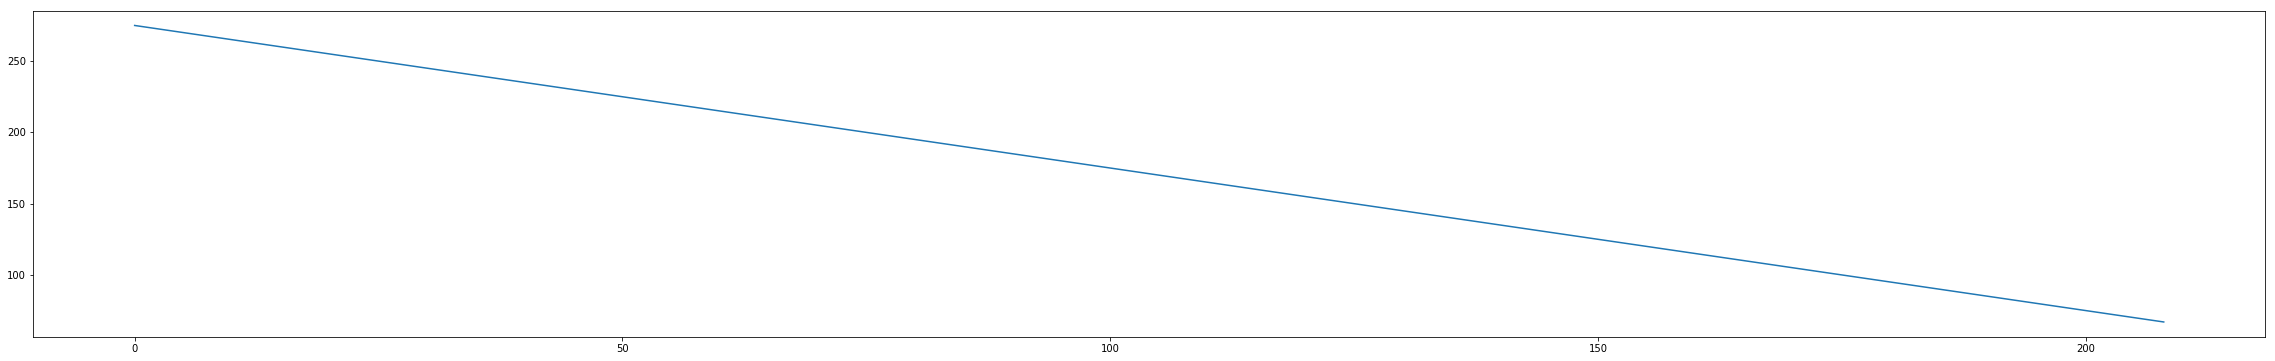

In [29]:
plt.figure(figsize=(40,6))
plt.plot(test_y[0:209])

#### RUL summary

,RUL_actual
count,259.000000
mean,81.185328
std,53.882916
min,6.000000
25%,35.000000
50%,80.000000
75%,121.000000
max,194.000000


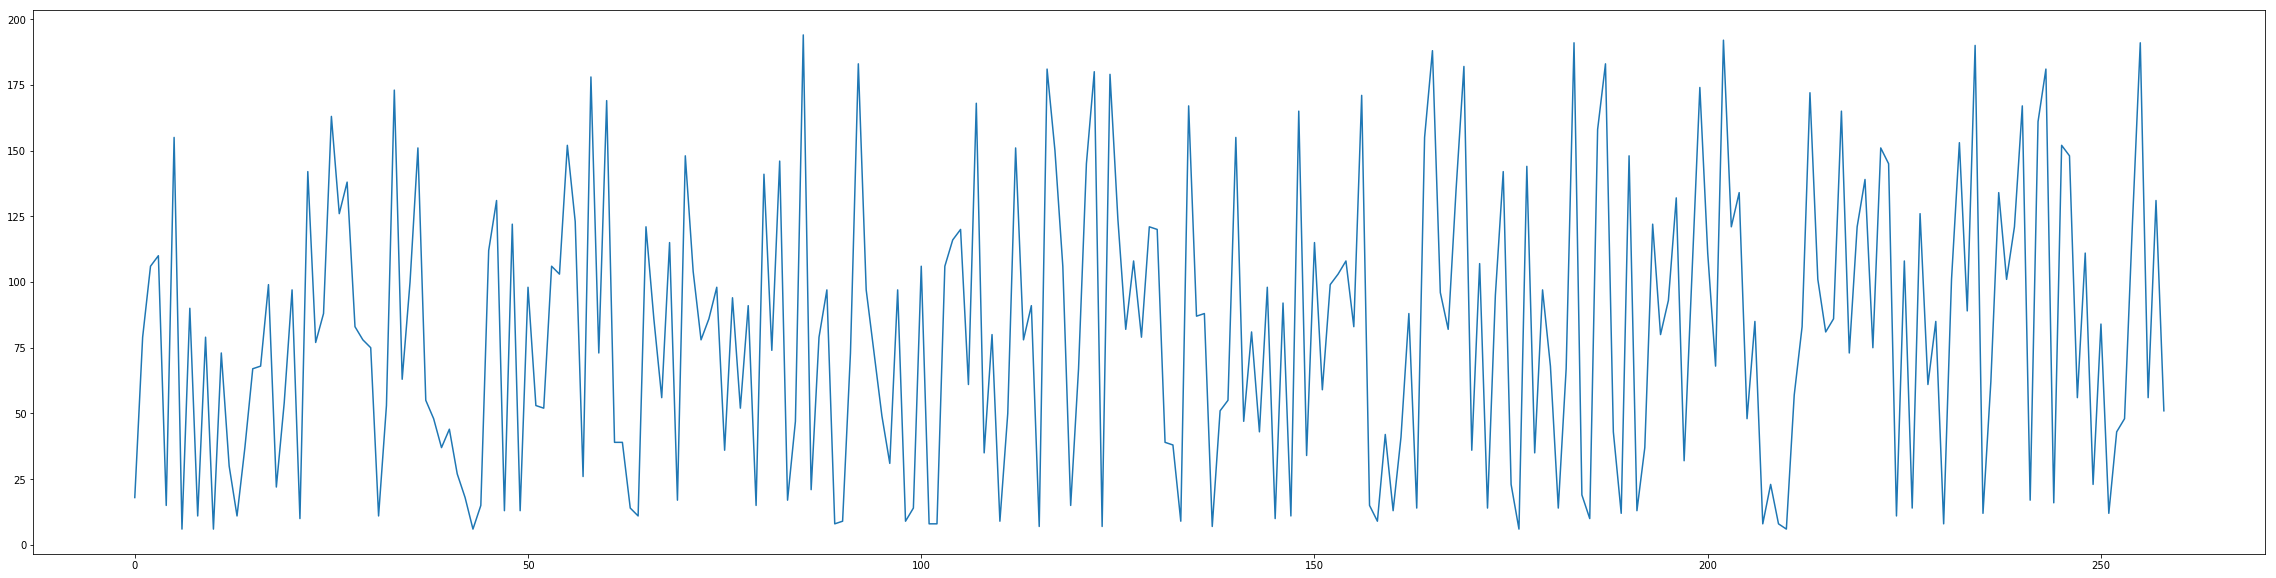

In [30]:
plt.figure(figsize=(40,10))
plt.plot(test_rul_df)
test_rul_df.describe()

#### Cycle summary

count    259.000000
mean     131.239382
std       63.085925
min       21.000000
25%       76.500000
50%      132.000000
75%      168.000000
max      367.000000
Name: cycles, dtype: float64

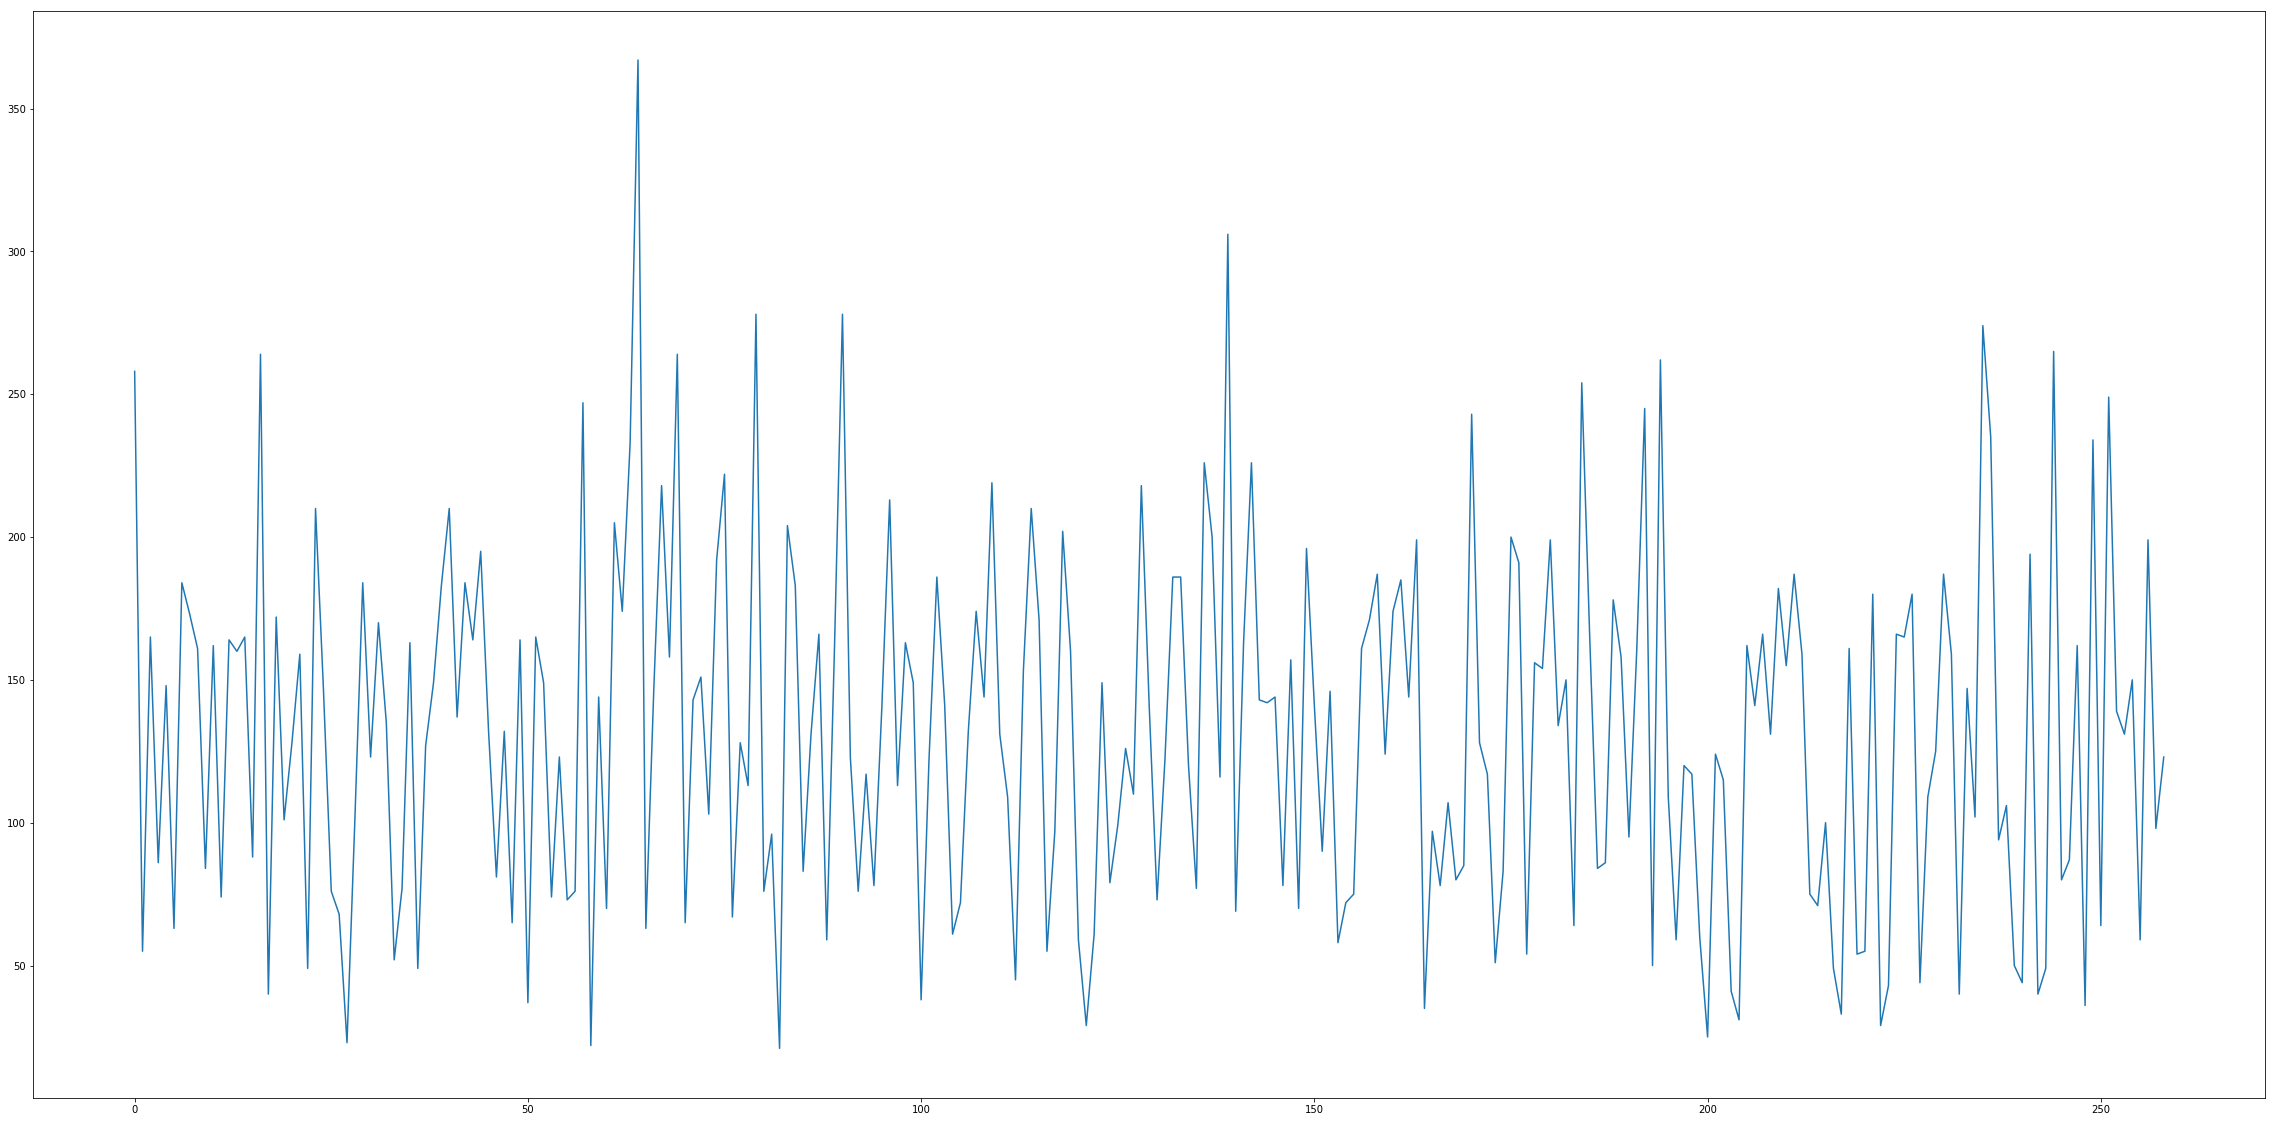

In [31]:
plt.figure(figsize=(40,20))
plt.plot(test_cycle_count_df['cycles'])
test_cycle_count_df['cycles'].describe()

In [32]:
# training metrics
score = model.evaluate(test_X, test_y, verbose=1, batch_size=batch_size)
print('Test score:', score)


19900/19900 [==============================] - 3s 126us/step
Test score: [34.955072144168106, 1697.1044256699145, 30.252054926139028]


In [33]:
y_pred_array = model.predict(test_X, verbose=1, batch_size=batch_size)


19900/19900 [==============================] - 2s 123us/step


In [34]:
def plot_prediction(rul_actual, rul_predicted):    
    plt.scatter(rul_actual, rul_predicted, marker='.')
    plt.plot(rul_actual, rul_actual, 'r')
    plt.xlabel("RUL actual")
    plt.ylabel("RUL predicted")

    plt.show()

In [35]:
y_pred_array.shape

(19900, 1)

In [36]:
#plot_prediction(test_rul_df.values.flatten(), y_pred_array[:259])

In [37]:
test_rul_df.values.flatten().shape

(259,)

In [38]:
test_y.shape

(19900, 1)

In [39]:
y_pred_array.shape

(19900, 1)

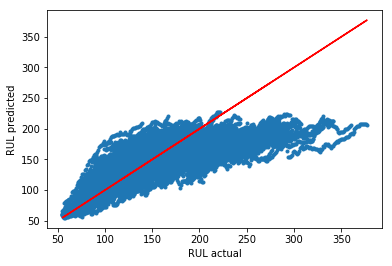

In [40]:
plot_prediction(test_y, y_pred_array)

## Prediction

Keras requires that you use same batch size in predicting as you used when training.

In [41]:
def single_engine(engine_id, feature_cols, label_cols, seq_length=50):
    engine_df = test_data_generator.data[engine_id].data_df
    
    num_entries = engine_df.shape[0]
    padding_batch = batch_size - num_entries // seq_length - 1
    padding_count = seq_length - (num_entries % seq_length)
    inf_X = np.zeros((padding_count+(padding_batch*seq_length), len(feature_cols)))
    inf_y = np.zeros((padding_count, len(label_cols)))

    data_X = engine_df[feature_cols].values
    data_y = engine_df[label_cols].values

    X = np.concatenate((inf_X, data_X))
    y = np.concatenate((inf_y, data_y))

    num_batches = X.shape[0] // seq_length
    X.resize( num_batches, seq_length, len(feature_cols))
    y.resize( num_batches, seq_length, len(label_cols))
    
    #print("entries={}, batch_size={}, padbatch={}, padCount={}".format( num_entries, batch_size, padding_batch, padding_count))
    #print(test_df[ test_df['id'] == engine_id]['RUL'].head(5).values)
    final_rul = test_df[ test_df['id'] == engine_id]['RUL'].tail(1).values[0]

    #print(test_df[ test_df['id'] == engine_id]['RUL'].tail(5).values)

    return X, y, num_entries, padding_batch, final_rul

In [42]:
#X, y, n, p, rul = single_engine(6016, feature_cols, label_cols)
#y_pred_array = model.predict(X, verbose=1, batch_size=batch_size)
#y_pred_array[p-100:]

In [43]:
def predict_engine_rul( engine_id):
    X, y, n, p, rul = single_engine(engine_id, feature_cols, label_cols)
    y_pred_array = model.predict(X, verbose=0, batch_size=batch_size)
    #print(engine_id, rul, y_pred_array[-1:][0,0])
    return engine_id, rul, y_pred_array[-1:][0,0]

Run prediction on all engines in the dataset. Then we will plot the results to see how we did.

In [44]:
results = []
for k, v in test_data_generator.data.items():
    results.append(predict_engine_rul(k))
results = np.array(results)

Data set:  FD002
Model:     ./model/engine20181225T1856/engine_model.h5
Scalar:    ./model/engine20181225T1856//engine_scaler.pkl
Score:     [34.955072144168106, 1697.1044256699145, 30.252054926139028]


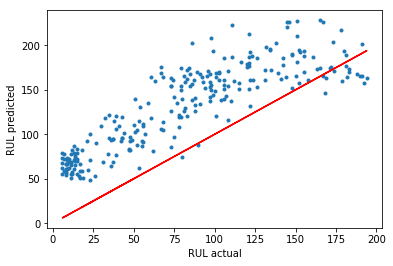

In [45]:
print("Data set: ", dataset_name)
print("Model:    ", model_path)
print("Scalar:   ", scaler_path)
print("Score:    ", score)
plot_prediction( results[:,1], results[:,2])


In [ ]:
X, y, n, p, rul = single_engine(6001, feature_cols, label_cols)
y_pred_array = model.predict(X, verbose=0, batch_size=batch_size)